In [4]:
# ✅ to remove, just for testing models
import math
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pickle

import numpy as np
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import get_scorer, make_scorer
from interpret.glassbox import ExplainableBoostingRegressor
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')

In [5]:
df_preprocessed = pd.read_csv(r"data_preprocessed\with_outliers.csv")

In [6]:
df_preprocessed = pd.read_csv(r"data_preprocessed\without_categorical.csv")

# Models

In [7]:
## Train / test split 
y = df_preprocessed.pop('average_rating')

X_train, X_test, y_train, y_test = train_test_split(df_preprocessed, y, test_size=0.3, random_state=42)

In [8]:
## Result Tab
global_result = pd.DataFrame(columns=['model name','RMSE','mae','r2_score'])

## Baseline

In [9]:
len(y_test)

3339

In [10]:
mean_ratings = y_test.mean().round(2)
y_pred = np.full((len(y_test)), mean_ratings)
y_pred

array([3.93, 3.93, 3.93, ..., 3.93, 3.93, 3.93])

### Metrics

In [11]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'Linear regression','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
print(pred.head(5))

RMSE : 0.37753428370132325
mae : 0.23831686133572927
r2_score : -0.0
   Actual  Predicted
0    3.67       3.93
1    4.17       3.93
2    3.63       3.93
3    3.89       3.93
4    3.70       3.93


## Linear Regression

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [13]:
y_pred = lr.predict(X_test)

### Metrics

In [14]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'Linear regression','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
print(pred.head(10))

RMSE : 0.36809874305274914
mae : 0.22545992030536458
r2_score : 0.05
   Actual  Predicted
0    3.67   3.870689
1    4.17   3.884548
2    3.63   3.785868
3    3.89   3.828071
4    3.70   4.054092
5    4.14   3.845104
6    3.90   4.036835
7    4.75   3.957228
8    4.04   4.023082
9    3.46   3.962900


##  Random forest

In [15]:
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [7, 10, 12, 15],
    'min_samples_split': [2,5],
    'min_samples_leaf': [5, 10, 15]
}
regr = RandomForestRegressor(random_state=0)

In [16]:
clf = GridSearchCV(estimator = regr, param_grid = parameters,cv=3,verbose=2, n_jobs = -1)

In [17]:
clf.fit(X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12, 15],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [18]:
clf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 200}

In [19]:
best_rf = clf.best_estimator_
y_pred = clf.predict(X_test)

In [20]:
importance_feature = pd.DataFrame(best_rf.feature_importances_,index=X_train.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)
importance_feature.sort_values(by=['Importance'],ascending=True,inplace=True)
importance_feature

,Importance
lang_ger,0.000006
lang_en-GB,0.000036
lang_spa,0.000089
lang_fre,0.000813
lang_others,0.001837
lang_en-US,0.002463
times_d1,0.003455
lang_eng,0.003689
times_d2,0.004301
editions_by_work,0.006714


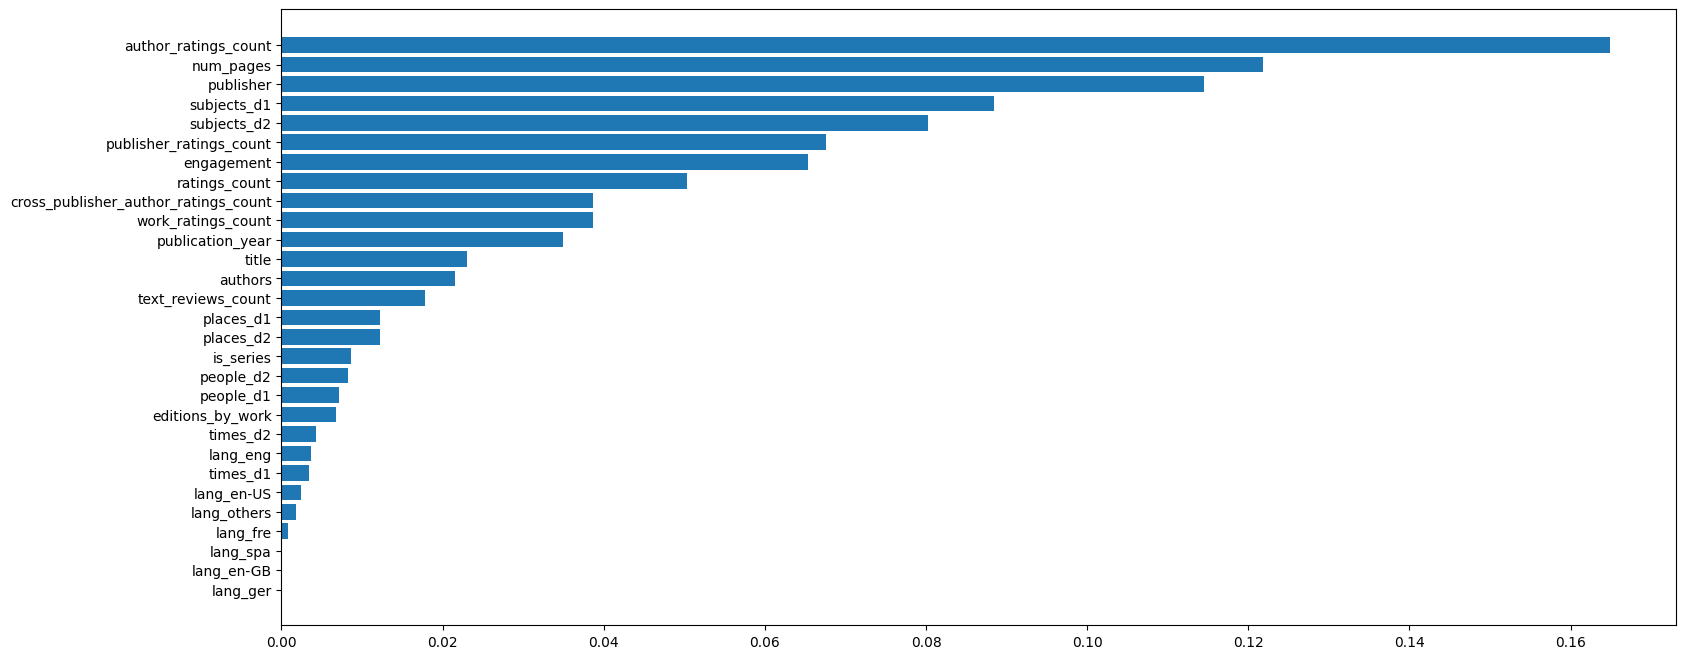

In [21]:
plt.figure(figsize=(18,8))
plt.barh(y=importance_feature.index,width=importance_feature.values.reshape((-1,)))
plt.show()

### Metrics

In [22]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2.round(2)}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'Random Forest','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
pred.head(5)

RMSE : 0.3174932847351653
mae : 0.20155107786601764
r2_score : 0.29


,Actual,Predicted
0,3.67,3.874661
1,4.17,3.818751
2,3.63,3.812280
3,3.89,3.746519
4,3.70,3.982845


## XGBoost

In [23]:
xgb = XGBRegressor()

In [24]:
parameters = {'nthread':[6],
              'objective':['reg:linear'],
              'learning_rate': [0.01,.03], #so called `eta` value
              'max_depth': [5,7,15],
              'subsample': [0.5],
              'n_estimators': [500,1000]}

In [25]:
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [26]:
xgb_grid.fit(X_train,y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[11:40:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.03], 'max_depth': [5, 7, 15],
                         'n_estimators': [500, 1000], 'nthread': [6],
                         'objective': ['reg:linear'], 'subsample': [0.5]},
             verbose=True)

In [27]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.2348196982676281
{'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 1000, 'nthread': 6, 'objective': 'reg:linear', 'subsample': 0.5}


In [28]:
optimal_xgb = xgb_grid.best_estimator_

In [29]:
y_pred = optimal_xgb.predict(X_test)

[0.01282128 0.         0.0305351  0.02613414 0.02090808 0.04636988
 0.02790418 0.0188556  0.03314568 0.05804021 0.04489298 0.03710097
 0.03153665 0.03211343 0.04001338 0.0363522  0.02981239 0.02935997
 0.02905973 0.0333801  0.02653265 0.03511926 0.03044808 0.02697613
 0.0484476  0.03132969 0.02120289 0.11401698 0.04759075]


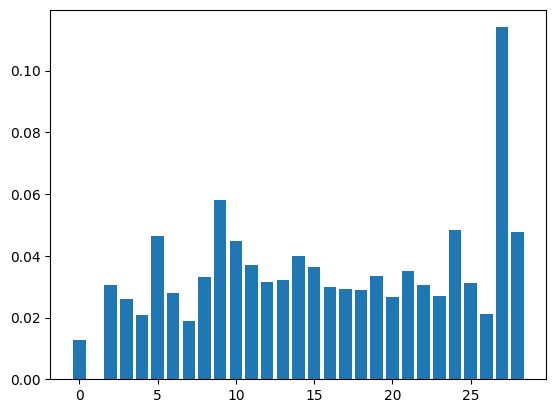

In [30]:
# feature importance
print(optimal_xgb.feature_importances_)
# plot
pyplot.bar(range(len(optimal_xgb.feature_importances_)), optimal_xgb.feature_importances_)
pyplot.show()

### Metrics

In [31]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2.round(2)}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'XGBoost','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)

RMSE : 0.3152025328994555
mae : 0.1933357128350097
r2_score : 0.3


# Results

In [32]:
global_result

,model name,RMSE,mae,r2_score
0,Linear regression,0.377534,0.238317,-0.0
1,Linear regression,0.368099,0.22546,0.05
2,Random Forest,0.317493,0.201551,0.29
3,XGBoost,0.315203,0.193336,0.3


In [33]:
pickle.dump(optimal_xgb, open("model/xgb_model.pkl", 'wb'))

In [34]:
# from sklearn_genetic.space import Categorical, Integer, Continuous
# from sklearn.model_selection import  StratifiedKFold
# from sklearn_genetic import GASearchCV


# clf =  RandomForestRegressor()
# #Choose the parameters range for the genetic algorithm
# #This part will change according to the classifier
# param_grid = { 
#             #'C': Continuous(0.0,10.0),
#               #'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
#               #'gamma': Categorical(['scale', 'auto']),
#               #'degree': Integer(3, 5),
#               #'gamma': Continuous(0.0, 10.0),
#               #'shrinking': Categorical([True, False]),
#               #'probability': Categorical([True, False]),
#               #'break_ties': Categorical([True, False]),
#               #'tol':Continuous(0.0,0.1)
#               #'decision_function_shape': Categorical(['ovr']),
#               #'kernel': Categorical([True, False]),
#               'max_depth': Integer(10, 100),
#               #'max_leaf_nodes': Integer(2, 35),
#               'n_estimators': Integer(100, 500),
#               'min_samples_split': Integer(2, 50),
#               'min_samples_leaf': Integer(5,50),
    
#             }


# evolved_estimator = GASearchCV(estimator=clf,
#                                cv=10,
#                                scoring='r2',
#                                population_size=5,
#                                generations=2,
#                                tournament_size=3,
#                                elitism=True,
#                                crossover_probability=0.8,
#                                mutation_probability=0.1,
#                                param_grid=param_grid,
#                                criteria='max',
#                                #algorithm='eaMuPlusLambda',
#                                n_jobs=-1,
#                                verbose=True,
#                                keep_top_k=4)


# evolved_estimator.fit(X_train,y_train)

# print(evolved_estimator.best_params_)

# pred_y_test = evolved_estimator.predict(X_test)

# print("******", "Testing Results" ,'******\n')
# preview_metrics(y_test, pred_y_test)

# XGBoost Categorical vs non categorical data

## Without categorical (label encoder)

In [35]:
df = pd.read_csv(r"data_preprocessed\without_categorical.csv")

In [36]:
df.dtypes

title                                     int64
authors                                   int64
average_rating                          float64
num_pages                                 int64
ratings_count                             int64
text_reviews_count                        int64
publisher                                 int64
publication_year                        float64
editions_by_work                        float64
work_ratings_count                      float64
author_ratings_count                      int64
publisher_ratings_count                   int64
cross_publisher_author_ratings_count      int64
is_series                                 int64
engagement                              float64
subjects_d1                             float64
subjects_d2                             float64
people_d1                               float64
people_d2                               float64
places_d1                               float64
places_d2                               

## With categorical 

In [37]:
df = pd.read_csv(r"data_preprocessed\with_categorical.csv")

In [38]:
df.sample(1)

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publisher,publication_year,editions_by_work,work_ratings_count,...,places_d2,times_d1,times_d2,lang_en-GB,lang_en-US,lang_eng,lang_fre,lang_ger,lang_others,lang_spa
3290,Peony in Love,Lisa See,3.6,273,37411,3719,Random House,2007.0,1.0,37411.0,...,-14.084662,-7.747457,29.864162,0,0,1,0,0,0,0


In [39]:
df.dtypes

title                                    object
authors                                  object
average_rating                          float64
num_pages                                 int64
ratings_count                             int64
text_reviews_count                        int64
publisher                                object
publication_year                        float64
editions_by_work                        float64
work_ratings_count                      float64
author_ratings_count                      int64
publisher_ratings_count                   int64
cross_publisher_author_ratings_count      int64
is_series                                 int64
engagement                              float64
subjects_d1                             float64
subjects_d2                             float64
people_d1                               float64
people_d2                               float64
places_d1                               float64
places_d2                               

In [40]:
df['title'] = df['title'].astype("category")
df['authors'] = df['authors'].astype("category")

In [41]:
X = df.drop("average_rating", axis=1)
y = df["average_rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [42]:
clf = xgb.XGBClassifier(
    tree_method="hist", enable_categorical=True, max_cat_to_onehot=1
)

AttributeError: 'XGBRegressor' object has no attribute 'XGBClassifier'

In [ ]:
clf.fit(X_train, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203], got [0.   1.67 2.   2.33 2.4  2.5  2.55 2.61 2.62 2.67 2.72 2.75 2.79 2.8
 2.81 2.82 2.83 2.86 2.88 2.89 2.92 2.93 2.94 2.96 2.98 2.99 3.   3.02
 3.04 3.06 3.07 3.08 3.09 3.1  3.11 3.12 3.13 3.14 3.15 3.16 3.17 3.18
 3.19 3.2  3.21 3.22 3.23 3.24 3.25 3.26 3.27 3.28 3.29 3.3  3.31 3.32
 3.33 3.34 3.35 3.36 3.37 3.38 3.39 3.4  3.41 3.42 3.43 3.44 3.45 3.46
 3.47 3.48 3.49 3.5  3.51 3.52 3.53 3.54 3.55 3.56 3.57 3.58 3.59 3.6
 3.61 3.62 3.63 3.64 3.65 3.66 3.67 3.68 3.69 3.7  3.71 3.72 3.73 3.74
 3.75 3.76 3.77 3.78 3.79 3.8  3.81 3.82 3.83 3.84 3.85 3.86 3.87 3.88
 3.89 3.9  3.91 3.92 3.93 3.94 3.95 3.96 3.97 3.98 3.99 4.   4.01 4.02
 4.03 4.04 4.05 4.06 4.07 4.08 4.09 4.1  4.11 4.12 4.13 4.14 4.15 4.16
 4.17 4.18 4.19 4.2  4.21 4.22 4.23 4.24 4.25 4.26 4.27 4.28 4.29 4.3
 4.31 4.32 4.33 4.34 4.35 4.36 4.37 4.38 4.39 4.4  4.41 4.42 4.43 4.44
 4.45 4.46 4.47 4.48 4.49 4.5  4.51 4.52 4.53 4.54 4.55 4.56 4.57 4.58
 4.59 4.6  4.61 4.62 4.63 4.64 4.65 4.67 4.69 4.7  4.71 4.72 4.73 4.75
 4.76 4.78 4.82 4.83 4.86 4.88 4.91 5.  ]

# Cross Validation

In [ ]:
#script for cross validation

#function to preview the results
def preview_metrics(YTrue, YPred):
        
        MAE = mean_absolute_error(YTrue, YPred)
        MSE = mean_squared_error(YTrue, YPred)
        R2 = r2_score(YTrue, YPred)
               
        print("MAE", MAE.round(4))
        print("RMSE", np.sqrt(MSE).round(4))
        print("R2:",R2.round(2))


models = [
     
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    AdaBoostRegressor(),
    ExplainableBoostingRegressor(),
    MLPRegressor(),
    #GaussianProcessRegressor()
]

models_names = [ 
    
       
    'Linear Regression',
    'Decision Tree',
    'Random Forest',
    'XGB',
    'Ada Boost',
    'Explainable Boosting', 
    'MLP',
    #'GaussianProcessRegressor'
        
]



for model, name in zip(models, models_names):
        
    #fit model
    #model.fit(X_train,y_train)
    
    scoring = ['r2','neg_mean_absolute_error','neg_root_mean_squared_error']
    scores = cross_validate(model, X_train,y_train, cv=10, scoring=scoring, return_estimator=True)
    #print("HERE ScorEs",scores['test_neg_root_mean_squared_error'])    
    INDEX = np.argmax(scores['test_r2'])    
    #print('INDEX', INDEX)    
    bestModel = scores['estimator'][INDEX]
    pred_y_test = bestModel.predict(X_test)
    pred_y_train = bestModel.predict(X_train)
       
    print("\n***************************")
    print("*****", name ,'******')
    print("***************************")
    #print("\n******", "Training Results" ,'******\n')
    #preview_metrics(y_train, pred_y_train)  
    print("******", "Testing Results" ,'******\n')
    preview_metrics(y_test, pred_y_test)



ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Dethoor\Miniconda3\envs\dstiml\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Dethoor\Miniconda3\envs\dstiml\Lib\site-packages\sklearn\linear_model\_base.py", line 656, in fit
    X, y, X_offset, y_offset, X_scale = _preprocess_data(
                                        ^^^^^^^^^^^^^^^^^
  File "c:\Users\Dethoor\Miniconda3\envs\dstiml\Lib\site-packages\sklearn\linear_model\_base.py", line 230, in _preprocess_data
    X = check_array(X, copy=copy, accept_sparse=["csr", "csc"], dtype=FLOAT_DTYPES)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dethoor\Miniconda3\envs\dstiml\Lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dethoor\Miniconda3\envs\dstiml\Lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Death Note  Vol. 8: Target (Death Note  #8)'

--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Dethoor\Miniconda3\envs\dstiml\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Dethoor\Miniconda3\envs\dstiml\Lib\site-packages\sklearn\linear_model\_base.py", line 656, in fit
    X, y, X_offset, y_offset, X_scale = _preprocess_data(
                                        ^^^^^^^^^^^^^^^^^
  File "c:\Users\Dethoor\Miniconda3\envs\dstiml\Lib\site-packages\sklearn\linear_model\_base.py", line 230, in _preprocess_data
    X = check_array(X, copy=copy, accept_sparse=["csr", "csc"], dtype=FLOAT_DTYPES)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dethoor\Miniconda3\envs\dstiml\Lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dethoor\Miniconda3\envs\dstiml\Lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'The Deming Management Method'
